In [1]:
import matplotlib.pyplot as plt
import numpy as np

import metpy.calc
import metpy.units

import xarray as xr

import sys  
sys.path.insert(0, '../')

from soundings.utils import radiosonde_products

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
vol = '/Users/stock/Development/research/soundings/data/raobs/arm-sgp/'

##### moist lapse rate
slope in pressure coordinates
$$\frac{\partial T}{\partial P} = \Big(\frac{1}{P}\Big) \frac{R_d T + L_v r_s}{C_{pd} + \frac{L_v^2 r_s \epsilon}{R_d T^2}} : b = 1$$

#### dry lapse rate

$${T_f} = T_i(P_f / P_i)^{b(R_d/C_{pd})}$$

slope in pressure coordinates
$$\frac{\partial T}{\partial P} = \frac{b R_d T}{C_{pd} P}$$

slope in height coordinates
$$
\begin{align}
\frac{\partial T}{\partial z} &= -(g/C_{pd})b(T/T_v) \equiv -\Gamma_d \\
&\approx -(g/C_{pd}) \approx -9.76^\circ \text{C km}^{-1}
\end{align}
$$

In [3]:
def approx_hypsometric(P, T):
    """hypsometric formula approximation"""
    return ((((1013.25/P)**(1/5.257) - 1) * (T+273.15)) / 0.0065)

def hypsometric(P, T, Td):
    """
    An equation relating the thickness between two isobaric surfaces 
    to the mean virtual temperature of the layer.
    
    Virtual temperature formula
        https://www.weather.gov/media/epz/wxcalc/virtualTemperature.pdf
    Hypsometric formula
        Wallace, J. M., and P. V. Hobbs, 1977: Atmospheric Science: 
        An Introductory Survey. Academic Press, 55–57.
    """
    e_0 = 6.11 # vapor pressure at t_0 hPa 
    t_0 = 273.16 # freezing point K
    
    e = e_0 * 10**(7.5 * Td / (237.7 + Td)) # vapor pressure
    T_v = ((T + t_0) / (1 - 0.379 * (e / P[0]))) # virtual temp K
    
    T_v_m = np.zeros(T_v.shape, dtype=np.float64) # mean T_v of prior values
    for i in range(T_v.size):
        T_v_m[i] = np.mean(T_v[:i+1])
    
    R_d = 287 # J K^-1 kg^-1 gas constant (dry air)
    g = 9.807 # earth gravity
    
    return (R_d * T_v_m) / g * np.log(1013.25/P)

In [3]:
fin = vol + '2001/sgpsondewnpnC1.b1.20010401.112900.cdf'
xar = xr.open_dataset(fin)

In [4]:
p = xar.pres.values
t = xar.tdry.values
td = xar.dp.values
ws = xar.wspd.values
wd = xar.deg.values
lat = xar.lat.values
lon = xar.lon.values
alt = xar.alt.values / 1000

In [8]:
m_100 = np.argmin(abs(p - 200))

p = p[:m_100]
t = t[:m_100] 
td = td[:m_100]
alt = alt[:m_100]

dry_lapse = metpy.calc.thermo.dry_lapse(p * metpy.units.units.hPa, t[0] * metpy.units.units.degC).to('degC').m

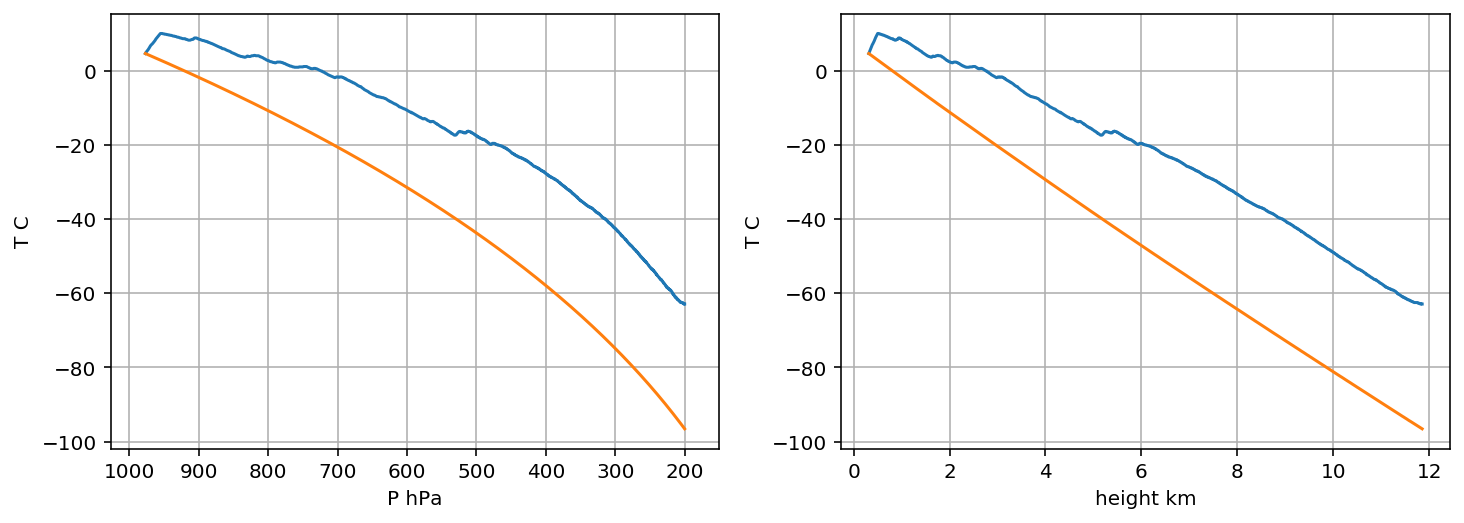

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(p, t)
axs[0].plot(p, dry_lapse)
axs[0].set_xlabel('P hPa')
axs[0].set_ylabel('T C')
axs[0].set_xlim(p.max()+50, p.min()-50)
axs[0].grid(True)

axs[1].plot(alt, t)
axs[1].plot(alt, dry_lapse)
axs[1].set_xlabel('height km')
axs[1].set_ylabel('T C')
axs[1].grid(True)

-6.089823 -8.762923


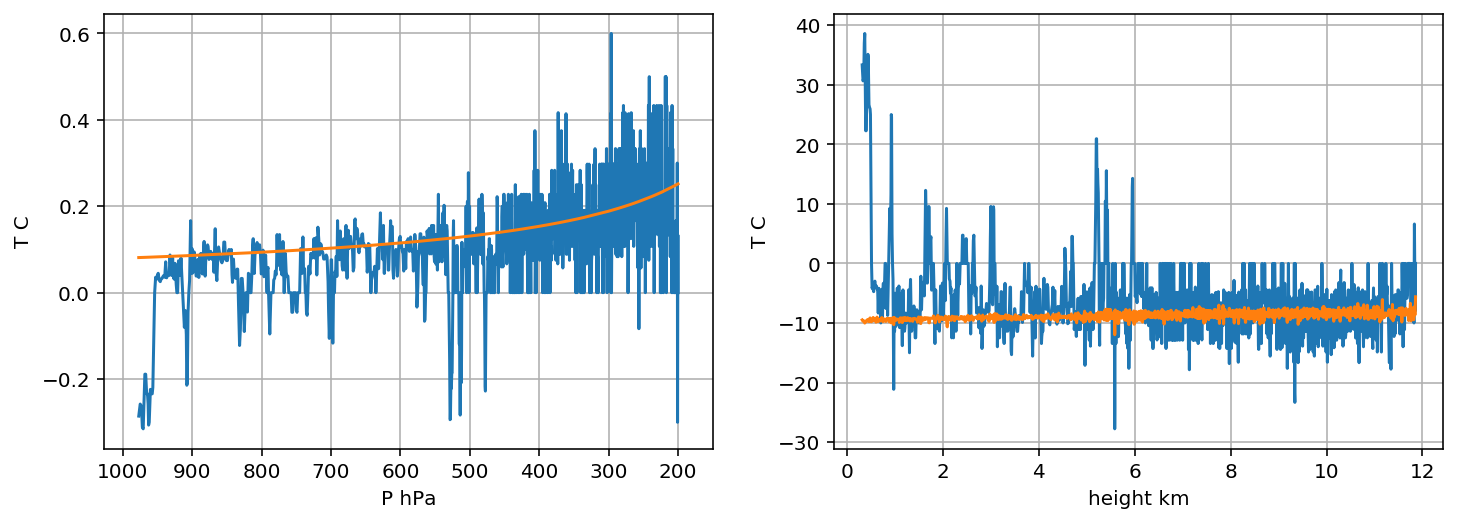

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(p, np.gradient(t, p))
axs[0].plot(p, np.gradient(dry_lapse, p))
axs[0].set_xlabel('P hPa')
axs[0].set_ylabel('T C')
axs[0].set_xlim(p.max()+50, p.min()-50)
axs[0].grid(True)

axs[1].plot(alt, np.gradient(t, alt))
axs[1].plot(alt, np.gradient(dry_lapse, alt))
axs[1].set_xlabel('height km')
axs[1].set_ylabel('T C')
axs[1].grid(True)
print(np.mean(np.gradient(t, alt)), np.mean(np.gradient(dry_lapse, alt)))

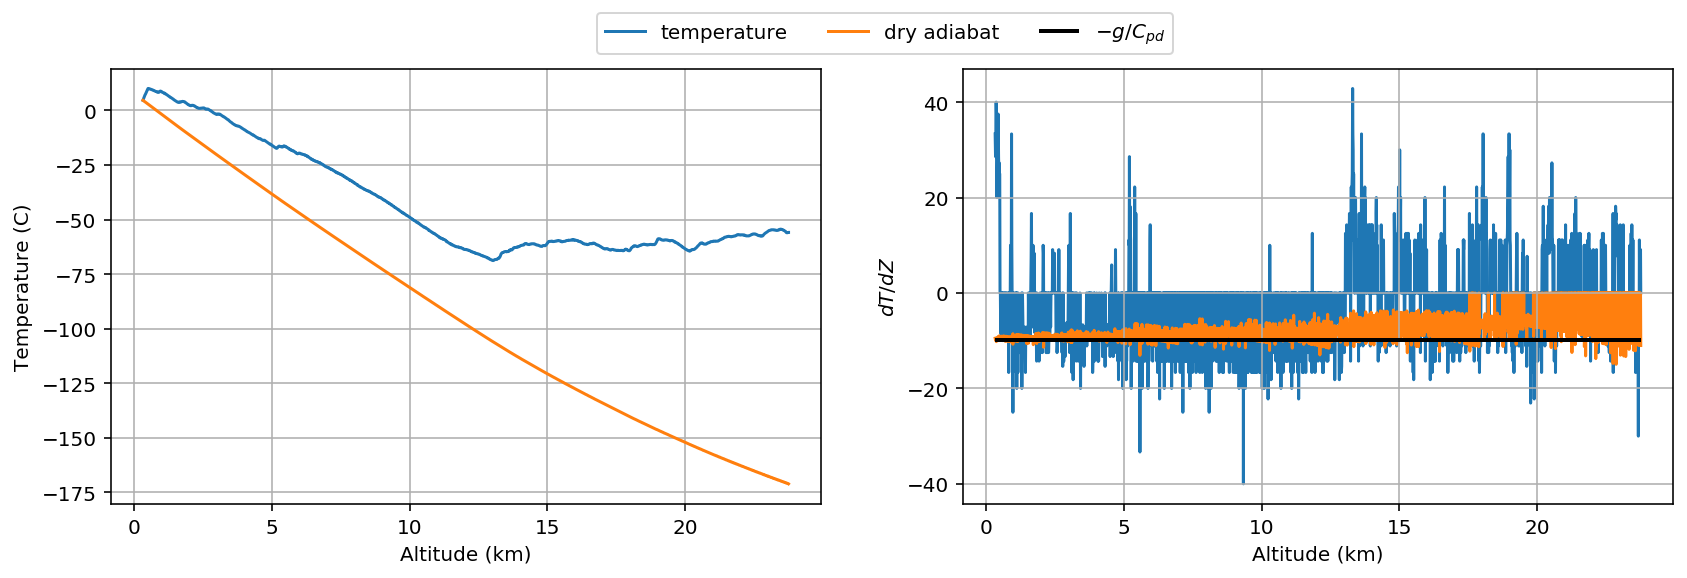

In [41]:
fin = vol + '2001/sgpsondewnpnC1.b1.20010401.112900.cdf'
xar = xr.open_dataset(fin)

p = xar.pres.values
t = xar.tdry.values
alt = xar.alt.values / 1000

dry_lapse = metpy.calc.thermo.dry_lapse(p * metpy.units.units.hPa, 
                                        t[0] * metpy.units.units.degC).to('degC').m

deltas = []
deltas_lapse = []

alt_prev = 0
t_prev = 0
lapse_prev = 0

for alt_curr, t_curr, lapse_curr in zip(alt, t, dry_lapse):
    dT = t_curr - t_prev
    dZ = alt_curr - alt_prev
    deltas.append(dT/dZ)
    
    dTl = lapse_curr - lapse_prev
    deltas_lapse.append(dTl/dZ)
    
    alt_prev = alt_curr
    t_prev = t_curr
    lapse_prev = lapse_curr

# deltas = deltas[::-1]
# deltas_lapse = deltas_lapse[::-1]
    
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(alt, t)
axs[0].plot(alt, dry_lapse)
axs[0].grid(True)
axs[0].set_xlabel('Altitude (km)')
axs[0].set_ylabel('Temperature (C)')

axs[1].hlines(-9.76, alt[1:].min(), alt.max(), label='$-g/C_{pd}$', color='k', lw=2, zorder=2)
axs[1].plot(alt[1:], deltas[1:], zorder=1, label='temperature')
axs[1].plot(alt[1:], deltas_lapse[1:], zorder=1, label='dry adiabat')
axs[1].set_xlabel('Altitude (km)')
axs[1].set_ylabel('$dT/dZ$')
axs[1].grid(True)
axs.flatten()[-1].legend(loc='upper center', bbox_to_anchor=(-0.11, 1.15), ncol=3);

plt.savefig('sgp-adiabat', dpi=300)
plt.show();

In [42]:
window_s, window_e = 496, 515
alt = alt[window_s:window_e]
t = t[window_s:window_e]
dry_lapse = dry_lapse[window_s:window_e]
deltas = deltas[window_s:window_e]
deltas_lapse = deltas_lapse[window_s:window_e]

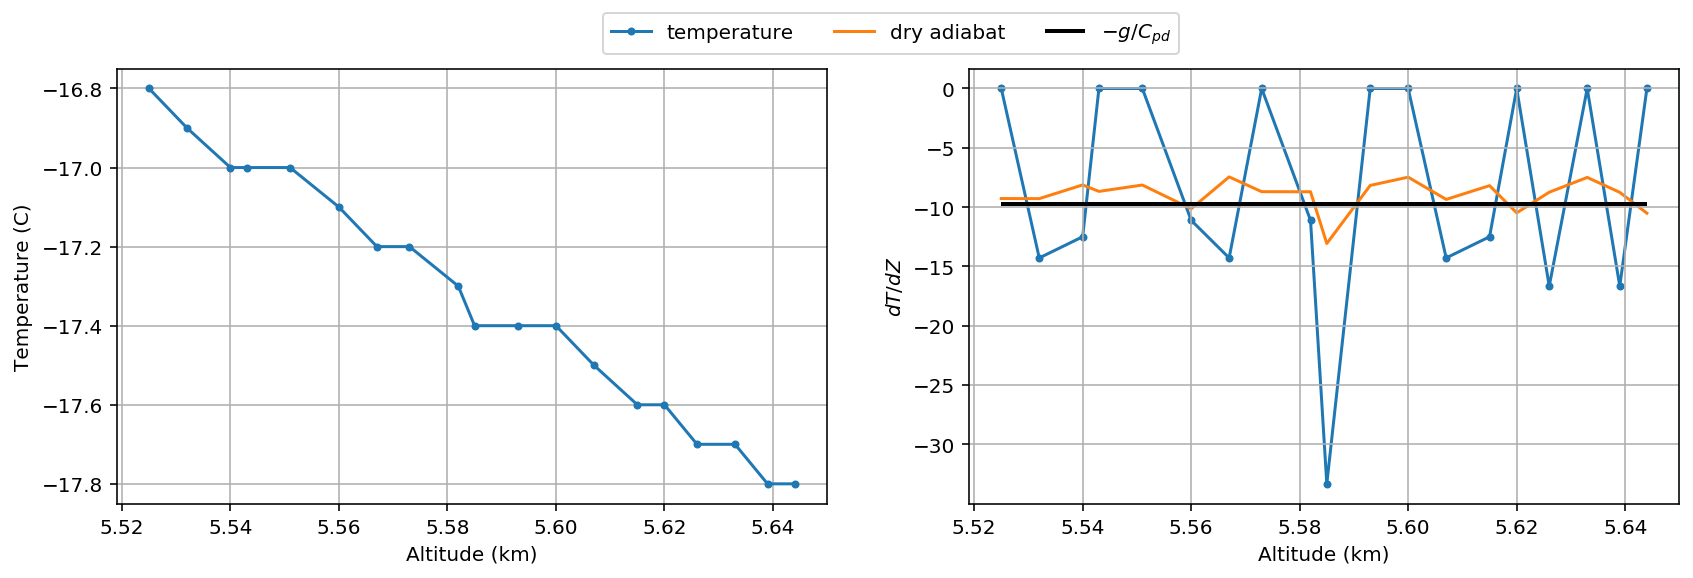

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(alt, t, '.-')
axs[0].grid(True)
axs[0].set_xlabel('Altitude (km)')
axs[0].set_ylabel('Temperature (C)')

axs[1].hlines(-9.76, alt.min(), alt.max(), label='$-g/C_{pd}$', color='k', lw=2, zorder=2)
axs[1].plot(alt, deltas, '.-', zorder=1, label='temperature')
axs[1].plot(alt, deltas_lapse, zorder=1, label='dry adiabat')
axs[1].set_xlabel('Altitude (km)')
axs[1].set_ylabel('$dT/dZ$')
axs[1].grid(True)

axs.flatten()[-1].legend(loc='upper center', bbox_to_anchor=(-0.11, 1.15), ncol=3);
plt.savefig('sgp-adiabat-window-2', dpi=300)
plt.show();

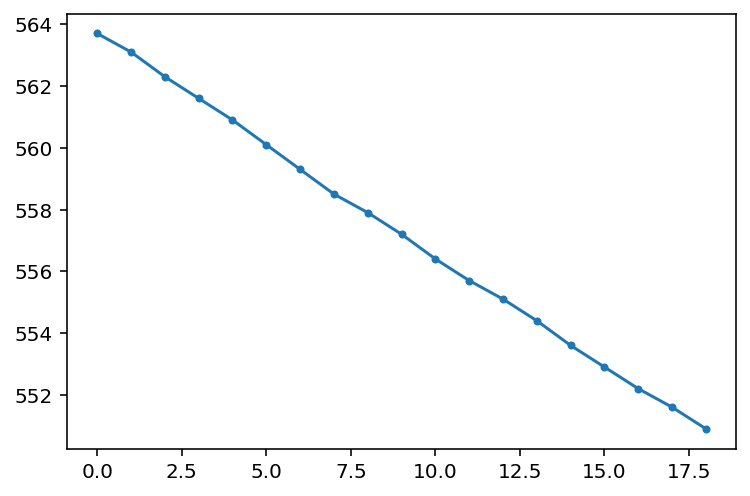

In [15]:
plt.plot(p[window_s:window_e], '.-')
axs[1].grid(True)

In [9]:
radiosonde_products.assert_dewpt_lte_temp(t, td)

True

In [ ]:
import scipy.integrate as si

def dt(t, p):
    """Slope of the dry adiabat in pressure coordinates
    """
    R = molar_gas_constant = 8.3144598 # J / (K mol)
    Md = dry_air_molecular_weight = 28.9644 # 'g / mol'
    Rd = dry_air_gas_constant = R / Md
    Cp_d = dry_air_spec_heat = 1.005 # 'kJ / kg K'
    
    return (Rd*t)/(Cp_d*p)

# this does not do what I expected
dl = si.solve_ivp(dt, t, p)